# Introduction
#### James Case
In this project, you will build a neural network of your own design to evaluate the CIFAR-10 dataset.
Our target accuracy is 70%, but any accuracy over 50% is a great start.
Some of the benchmark results on CIFAR-10 include:

78.9% Accuracy | [Deep Belief Networks; Krizhevsky, 2010](https://www.cs.toronto.edu/~kriz/conv-cifar10-aug2010.pdf)

90.6% Accuracy | [Maxout Networks; Goodfellow et al., 2013](https://arxiv.org/pdf/1302.4389.pdf)

96.0% Accuracy | [Wide Residual Networks; Zagoruyko et al., 2016](https://arxiv.org/pdf/1605.07146.pdf)

99.0% Accuracy | [GPipe; Huang et al., 2018](https://arxiv.org/pdf/1811.06965.pdf)

98.5% Accuracy | [Rethinking Recurrent Neural Networks and other Improvements for ImageClassification; Nguyen et al., 2020](https://arxiv.org/pdf/2007.15161.pdf)

Research with this dataset is ongoing. Notably, many of these networks are quite large and quite expensive to train. 

## Imports

In [1]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

## Load the Dataset

Specify your transforms as a list first.
The transforms module is already loaded as `transforms`.

CIFAR-10 is fortunately included in the torchvision module.
Then, you can create your dataset using the `CIFAR10` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/docs/stable/torchvision/datasets.html#cifar)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [2]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [3]:
# Define transforms
train_transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                transforms.ToTensor()])
transform = transforms.Compose([transforms.ToTensor()])


# Create training set and define training dataloader
data_dir = 'CIFAR10'

#create validation set from training subset
dataset = torchvision.datasets.CIFAR10(data_dir, train=True, transform=train_transform,download=True)
train_data, valid_data = torch.utils.data.random_split(dataset,[40000,10000])

test_data = torchvision.datasets.CIFAR10(data_dir,train=False, transform=transform, download=True)


#Batchsize could possibly be loader
# Create test set and define test dataloader
train_loader = torch.utils.data.DataLoader(train_data, batch_size=256, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=256)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=256)
# The 10 classes in the dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [4]:
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(classes[labels[i]])
    
        image = images[i].numpy()
        plt.imshow(image.T)
        plt.show()

bird


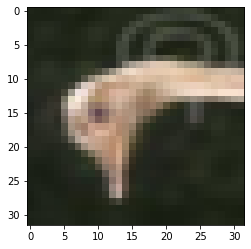

ship


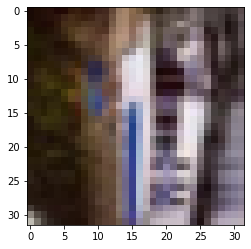

car


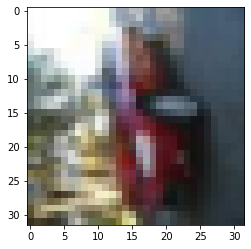

horse


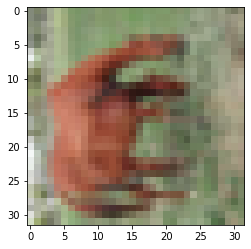

truck


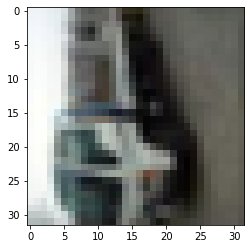

In [5]:
# Explore data

show5(train_loader)

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset. 
Feel free to construct a model of any architecture – feedforward, convolutional, or even something more advanced!

In [6]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.fc1 = nn.Linear(3072,1024)
        self.fc2 = nn.Linear(1024,512)
        self.fc3 = nn.Linear(512,256)
        self.fc4 = nn.Linear(256,10)
        
        #Set dropout to 20%
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x):
        #flatten inputs
        x = x.view(x.shape[0],-1)
        
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x 
    
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(3,64,kernel_size=(3,3),padding=(1,1))
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(64,128,kernel_size=(3,3),padding=(1,1))
        self.fc1 = nn.Linear(128*8*8,256)
        self.fc2 = nn.Linear(256,64)
        self.fc3 = nn.Linear(64,10)
        
        self.dropout = nn.Dropout(p=0.2)
    def forward(self,x):
        
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        
        x = x.view(x.shape[0],-1)
        
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        
        x = F.log_softmax(self.fc3(x), dim=1)    
        
        return x

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [7]:
model = ConvNet()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
model

ConvNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=8192, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss during each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device);
#torch.cuda.current_device()
#torch.cuda.get_device_name()

In [9]:
import time

In [10]:
epochs = 30
train_losses=[]
test_losses=[]

def train_test(epochs,model, trainloader, testloader, criterion, optimizer):
    for epoch in range(epochs):
        running_loss = 0
        #start = time.time()
        for images, labels in train_loader:


            optimizer.zero_grad()

            images, labels = images.to(device), labels.to(device)

            logps = model.forward(images)
            loss = criterion(logps, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            
        else:

            test_loss = 0
            accuracy = 0

            with torch.no_grad():
                model.eval()
                for images, labels in testloader:
                    images, labels = images.to(device), labels.to(device)

                    logps = model.forward(images)
                    test_loss += criterion(logps, labels)

                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor))

            model.train()        

            train_losses.append(running_loss/len(trainloader))
            test_losses.append(test_loss/len(testloader))

            print(f"Epoch {epoch+1}/{epochs}.. "
                      f"Train loss: {running_loss/len(trainloader):.3f}.. "
                      f"Test loss: {test_loss/len(testloader):.3f}.. "
                      f"Test accuracy: {accuracy/len(testloader):.3f}")
      
   

In [11]:
train_test(epochs,model, train_loader, valid_loader,criterion, optimizer)

Epoch 1/30.. Train loss: 1.709.. Test loss: 1.361.. Test accuracy: 0.506
Epoch 2/30.. Train loss: 1.354.. Test loss: 1.229.. Test accuracy: 0.554
Epoch 3/30.. Train loss: 1.189.. Test loss: 1.083.. Test accuracy: 0.612
Epoch 4/30.. Train loss: 1.078.. Test loss: 1.004.. Test accuracy: 0.637
Epoch 5/30.. Train loss: 0.994.. Test loss: 0.939.. Test accuracy: 0.661
Epoch 6/30.. Train loss: 0.919.. Test loss: 0.893.. Test accuracy: 0.685
Epoch 7/30.. Train loss: 0.856.. Test loss: 0.844.. Test accuracy: 0.705
Epoch 8/30.. Train loss: 0.813.. Test loss: 0.834.. Test accuracy: 0.712
Epoch 9/30.. Train loss: 0.766.. Test loss: 0.838.. Test accuracy: 0.710
Epoch 10/30.. Train loss: 0.727.. Test loss: 0.841.. Test accuracy: 0.706
Epoch 11/30.. Train loss: 0.683.. Test loss: 0.796.. Test accuracy: 0.721
Epoch 12/30.. Train loss: 0.649.. Test loss: 0.790.. Test accuracy: 0.733
Epoch 13/30.. Train loss: 0.613.. Test loss: 0.782.. Test accuracy: 0.730
Epoch 14/30.. Train loss: 0.580.. Test loss: 0.

Plot the training loss (and validation loss/accuracy, if recorded).

In [12]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

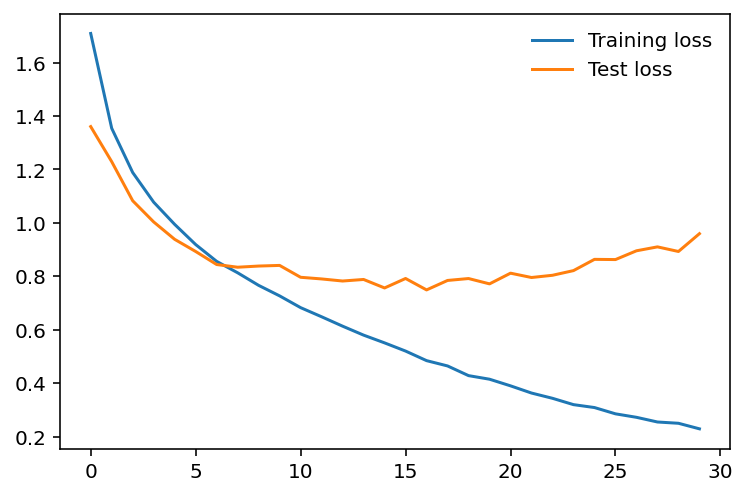

In [13]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Test loss')
plt.legend(frameon=False)

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 70%, great work! 
This is a hard task to exceed 70% on.

If your accuracy is under 45%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [14]:
total = 0
correct = 0

model.eval()
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy: %d %%' % (100 * correct / total))


Accuracy: 75 %


## Saving your model
Using `torch.save`, save your model for future loading.

In [15]:
model.state_dict()

OrderedDict([('conv1.weight',
              tensor([[[[-1.8953e-01, -1.3826e-01, -5.2203e-02],
                        [ 6.8644e-02, -1.9276e-01, -1.6516e-01],
                        [ 1.3980e-01,  3.1926e-01,  1.0271e-01]],
              
                       [[-1.8434e-01, -1.9526e-01,  1.0569e-01],
                        [-2.1791e-01, -1.7675e-01,  5.5185e-02],
                        [ 1.3896e-01,  2.2826e-01,  1.0137e-01]],
              
                       [[-4.3325e-02, -1.3198e-01,  1.2601e-01],
                        [-2.5214e-01,  4.7583e-03, -8.8246e-03],
                        [ 2.3904e-02,  1.8958e-01,  7.4557e-02]]],
              
              
                      [[[-2.8166e-02,  8.5251e-02, -1.3224e-01],
                        [-6.7633e-02, -3.3377e-02, -5.1107e-02],
                        [-1.6539e-01, -2.1283e-01, -1.6469e-01]],
              
                       [[-3.4271e-02,  5.5517e-02,  9.9188e-02],
                        [ 1.3535e-01,  1.9981

In [16]:
torch.save(model.state_dict(), 'checkpoint.pth')

## Make a Recommendation

Based on your evaluation, what is your recommendation on whether to build or buy? Explain your reasoning below.

I would recommend building the model as the test accuracy is over 70%. Several improvements can be made such as fine tuning the batch size and the number and hyperparameters of the Convolutional Neural Network(CNN)(model name was ConvNet). The Deep Neural Network (DNN) with only linear layers (model name was Classifier) would not be recommended as it does a poor job and only scores around 51%. 